## Creating a Kaggle Workflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
print('Shape Train: ', train.shape)
print('Shape Test: ', holdout.shape)
print('Number of features Train: ', len(train.columns))
print('Number of features Test: ', len(holdout.columns))

Shape Train:  (891, 12)
Shape Test:  (418, 11)
Number of features Train:  12
Number of features Test:  11


In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def apply_fnc(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in cols:
        df = create_dummies(df, col)
    return df

In [6]:
train = apply_fnc(train)
holdout = apply_fnc(holdout)

In [7]:
family_cols = ['SibSp', 'Parch', 'Survived']
train[family_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


In [8]:
train[family_cols].head(3)

,SibSp,Parch,Survived
0,1,0,0
1,1,0,1
2,0,0,1


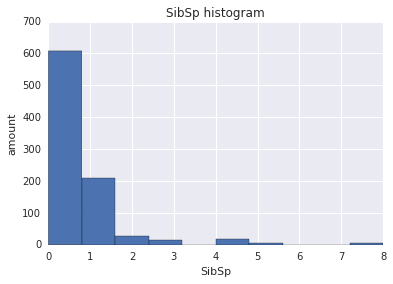

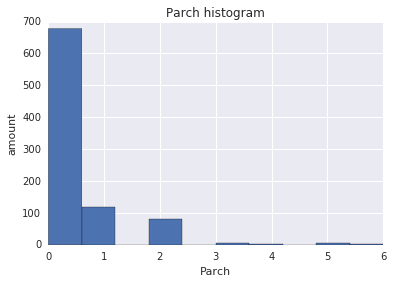

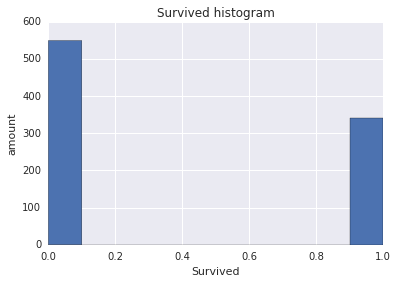

In [9]:
for col in family_cols:
    fig = plt.figure()
    plt.hist(train[col])
    plt.xlabel(col)
    plt.ylabel('amount')
    plt.title('{} histogram'.format(col))

These two columns have similar information about the family

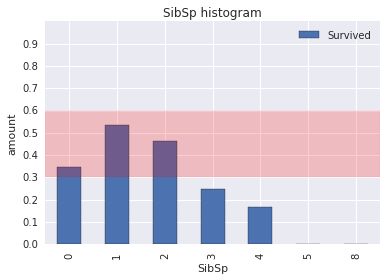

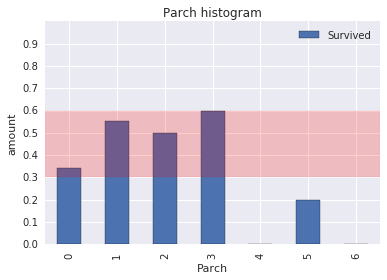

In [10]:
family_cols = ['SibSp', 'Parch']
for col in family_cols:
    fig = plt.figure()
    
    pivot = train.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.xlabel(col)
    plt.ylabel('amount')
    plt.title('{} histogram'.format(col))

## Engineer New Feature

In [11]:
print('Number of features: ', len(train.columns))
print('Number of features: ', len(holdout.columns))

Number of features:  43
Number of features:  41


In [12]:
def process_isalone(df):
    df['familysize'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['familysize'] == 0),"isalone"] = 1
    df = df.drop('familysize', axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In [13]:
print('Shape Train: ', train.shape)
print('Shape Test: ', holdout.shape)
print('Number of features Train: ', len(train.columns))
print('Number of features Test: ', len(holdout.columns))

Shape Train:  (891, 44)
Shape Test:  (418, 42)
Number of features Train:  44
Number of features Test:  42


In [14]:
# Not in holdout set
list(set(train.columns) - set(holdout.columns))

['Cabin_type_T', 'Survived']

In [15]:
# Ratio of alone passengers
train.isalone.value_counts(normalize=True)*100

1    60.26936
0    39.73064
Name: isalone, dtype: float64

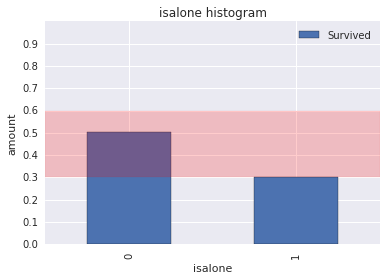

In [16]:
family_cols = ['isalone']
for col in family_cols:
    fig = plt.figure()
    
    pivot = train.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.xlabel(col)
    plt.ylabel('amount')
    plt.title('{} histogram'.format(col))

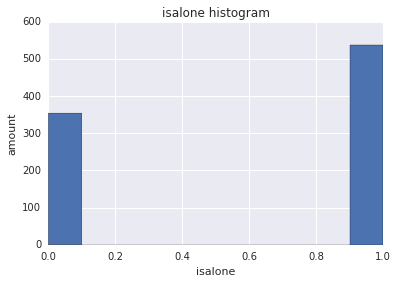

In [17]:
for col in family_cols:
    fig = plt.figure()
    plt.hist(train[col])
    plt.xlabel(col)
    plt.ylabel('amount')
    plt.title('{} histogram'.format(col))

## Feature Selection

In [25]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [26]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['Survived', 'PassengerId'], axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n" + "-"*12+"\n{}\n".format(best_columns))
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## HyperParameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [29]:
def select_model(df, feature_list):
    all_X = df[feature_list]
    all_y = df['Survived']
    
    models = [{"name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {"solver": ["newton-cg", "lbfgs", "liblinear"]}
        },
        {"name": "KNeighborsClassifier",
         "estimator": KNeighborsClassifier(),
         "hyperparameters":
                {"n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
                }
        },
        {"name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(random_state=1),
        "hyperparameters":
                {"n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
                }}]
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        
        grid = GridSearchCV(model['estimator'],
                           param_grid=model['hyperparameters'],
                           cv=10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print('Best Score: {}'.format(model['best_score']))
        print('Best Parameters: {}'.format(model['best_params']))
    return models

result = select_model(train, cols)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}
KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'n_neighbors': 5}
RandomForestClassifier
----------------------
Best Score: 0.8294051627384961
Best Parameters: {'n_estimators': 4, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_depth': 5}


In [30]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)

In [ ]:
result